# Identify and Plot MHWs

In [1]:
from datetime import datetime, timezone, timedelta
from itertools import groupby

import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
import pandas as pd
import xarray as xr
import math

from ormhw.core import *
from ormhw.noaa import import_oisstv2_sst_mean
from ormhw.transitions import CBR
from ormhw.mhw import get_90th_percentile, find_mhws

## Get Cell Specific Time-Series for CE04, CE02, and CE01

In [2]:
%%time
years = range(1983,2023)
ds4 = xr.Dataset()
ds2 = xr.Dataset()
ds1 = xr.Dataset()
for year in years:
    _ds = import_oisstv2_sst_mean([year])
    _ds['lon'] = ((_ds.lon + 180) % 360) - 180
    _ds4 = _ds.sel(lon = CE04_LOC[1], lat = CE04_LOC[0], method = 'nearest')
    _ds2 = _ds.sel(lon = CE02_LOC[1], lat = CE02_LOC[0], method = 'nearest')
    _ds1 = _ds.sel(lon = CE01_LOC[1], lat = CE01_LOC[0], method = 'nearest')
    ds4 = xr.merge([ds4, _ds4])
    ds2 = xr.merge([ds2, _ds2])
    ds1 = xr.merge([ds1, _ds1]) 

CPU times: user 10min 1s, sys: 17.6 s, total: 10min 19s
Wall time: 11min 34s


In [3]:
# Create tuples of cell lat/lon that represent the OOI sites.
ds4cell = (float(ds4.lat.values), float(ds4.lon.values))
ds2cell = (float(ds2.lat.values), float(ds2.lon.values))
ds1cell = (float(ds1.lat.values), float(ds1.lon.values))

## Compute Cell Specific Unsmoothed Climatology for CE04, CE02, and CE01

In [4]:
%%time
ds4clim = ds4.groupby('time.dayofyear').mean()
ds2clim = ds2.groupby('time.dayofyear').mean()
ds1clim = ds1.groupby('time.dayofyear').mean()

CPU times: user 562 ms, sys: 56.3 ms, total: 619 ms
Wall time: 612 ms


## Compute Cell Specific Unsmoothed 90th Percentile for CE04, CE02, and CE01

In [5]:
%%time
ds4_90 = get_90th_percentile(ds4)
ds2_90 = get_90th_percentile(ds2)
ds1_90 = get_90th_percentile(ds1)

CPU times: user 3.09 s, sys: 3.76 ms, total: 3.1 s
Wall time: 3.09 s


## Identify MHW Events at CE04, CE02, and CE01

In [6]:
%%capture
# Invalid computation warnings (div by 0) may appear, so we can capture them so the output is not flooded.
all_events4 = find_mhws(ds4, ds4clim, ds4_90)
all_events2 = find_mhws(ds2, ds2clim, ds2_90)
all_events1 = find_mhws(ds1, ds1clim, ds1_90)

In [7]:
median_duration = all_events4.D.median()
print(f'Median_duration: {median_duration} days')

Median_duration: 9.0 days


In [8]:
# Make a new data directory to save identified MHWs.
data_directory = f"{os.path.expanduser('~')}/oregon-shelf-mhw/data/mhws"
os.makedirs(data_directory, exist_ok = True)

In [9]:
# Whittle down to years of interest.
yoi4 = all_events4[all_events4.year >= 2015].reset_index(drop = True) 
yoi2 = all_events2[all_events2.year >= 2015].reset_index(drop = True)
yoi1 = all_events1[all_events1.year >= 2015].reset_index(drop = True)

#Save year of interest data for use in other notebooks.
yoi4.to_csv(f"{data_directory}/mhws_ce04.csv")
yoi2.to_csv(f"{data_directory}/mhws_ce02.csv")
yoi1.to_csv(f"{data_directory}/mhws_ce01.csv")

## LaTeX Output for MHWs at CE04

In [10]:
# Import Blobtracker data.
blobtracker = pd.read_csv(f"{os.path.expanduser('~')}/oregon-shelf-mhw/data/noaa/blobtracker_data.csv")

In [11]:
blobtracker['feature_name'] = blobtracker.feature_name.astype(str)
blobtracker = blobtracker[blobtracker.feature_name.str.contains('NEP')]
blobtracker['time'] = pd.to_datetime(blobtracker.time)
blobtracker['time'] = blobtracker['time'].dt.tz_localize(None)
blobtracker = blobtracker[blobtracker.time.dt.date >= datetime(2013,1,1).date()]
blobtracker = blobtracker.reset_index(drop = True)

In [12]:
# Print out yearday spans for each NEP Blob.
for idx, row in blobtracker.iterrows():
    print(row.feature_name, '|', row.time.strftime('%Y-%j'),'-',(row.time + timedelta(days = row.duration)).strftime('%Y-%j'))

NEP2013a | 2013-102 - 2013-170
NEP2013b | 2013-192 - 2013-269
NEP2013c | 2013-301 - 2015-331
NEP2015a | 2015-107 - 2015-152
NEP2015b | 2015-244 - 2015-283
NEP2015c | 2015-244 - 2015-280
NEP2016a | 2016-004 - 2016-127
NEP2016b | 2016-130 - 2016-353
NEP2017a | 2017-071 - 2017-131
NEP2017b | 2017-149 - 2017-287
NEP2017c | 2017-304 - 2017-353
NEP2018a | 2018-252 - 2019-005
NEP2019a | 2019-055 - 2019-102
NEP2019b | 2019-117 - 2019-141
NEP2019c | 2019-142 - 2020-011
NEP2020a | 2020-040 - 2020-173
NEP2020b | 2020-145 - 2021-076
NEP2021a | 2021-119 - 2021-167
NEP2021b | 2021-168 - 2021-356
NEP2022a | 2022-019 - 2022-212
NEP2022b | 2022-146 - 2022-171
NEP2022c | 2022-193 - 2023-136
NEP2022d | 2022-361 - 2023-037
NEP2023a | 2023-137 - 2023-168


In [13]:
years = range(2015,2023)
uw = pd.DataFrame()
for year in years:
    ydf = yoi4[yoi4.year == year]
    SF = CBR[year]
    ydf = ydf.reset_index(drop = True)
    i = 1
    for idx, row in ydf.iterrows():
        if SF['spring'] <= row.Ts <= SF['fall'] or SF['spring'] <= row.Te <= SF['fall'] or row.Ts <= SF['spring'] <=row.Te or row.Ts <= SF['fall'] <=row.Te:
            mhw_start = datetime.strptime(f"{year}-{row.Ts}", '%Y-%j')
            mhw_end = datetime.strptime(f"{year}-{row.Te}", '%Y-%j')
            for idx2, blob in blobtracker.iterrows():
                blob_start = blob.time
                blob_end = blob.time + timedelta(days = blob['duration'])
                if mhw_start <= blob_start <= mhw_end or mhw_start <= mhw_end <= mhw_end or blob_start <= mhw_start <= blob_end or blob_start <= mhw_end <= blob_end:
                    print(f"{row.year} & {i} & {row.Ts} & {row.Te} & {row.D} & {round(row.imax,2)} & {round(row.imean,2)} & {round(row.ivar,2)} & {round(row.ronset,2)} & {round(row.rdecline,2)} & \\\\")
                    i += 1
                    break

2015 & 1 & 1 & 111 & 110 & 2.86 & 2.0 & 0.33 & 0.98 & -1.44 & \\
2015 & 2 & 114 & 120 & 6 & 1.67 & 1.18 & 0.4 & 0.72 & -1.47 & \\
2015 & 3 & 204 & 209 & 5 & 2.82 & 2.49 & 0.24 & 1.62 & -1.0 & \\
2016 & 1 & 77 & 82 & 5 & 1.9 & 1.49 & 0.33 & 0.84 & -0.9 & \\
2016 & 2 & 90 & 103 & 13 & 2.14 & 1.68 & 0.27 & 0.75 & -1.13 & \\
2016 & 3 & 108 & 120 & 12 & 2.35 & 1.74 & 0.23 & 0.88 & -1.93 & \\
2016 & 4 & 150 & 158 & 8 & 2.18 & 1.69 & 0.32 & 0.55 & -1.25 & \\
2018 & 1 & 135 & 141 & 6 & 1.74 & 1.62 & 0.15 & 0.48 & -1.98 & \\
2018 & 2 & 157 & 162 & 5 & 1.87 & 1.69 & 0.19 & 0.76 & -1.63 & \\
2018 & 3 & 171 & 177 & 6 & 2.1 & 1.66 & 0.28 & 0.65 & -1.38 & \\
2019 & 1 & 190 & 199 & 9 & 3.18 & 2.64 & 0.23 & 1.34 & -1.22 & \\
2019 & 2 & 219 & 229 & 10 & 3.31 & 2.81 & 0.41 & 0.72 & -1.0 & \\
2019 & 3 & 242 & 280 & 38 & 4.57 & 2.82 & 1.03 & 1.16 & -0.77 & \\


## Identify MHW Prominence for 2019

In [14]:
yoi4_19 = yoi4[yoi4.year == 2019]
bdt = datetime.strptime(f'2019-{yoi4_19.Ts.min()}','%Y-%j')
edt = datetime.strptime(f'2019-{yoi4_19.Te.max()}','%Y-%j')
print(f"Min Day: {yoi4_19.Ts.min()}, ({bdt.date()})")
print(f"Min Day: {yoi4_19.Te.max()}, ({edt.date()})")

Min Day: 190, (2019-07-09)
Min Day: 280, (2019-10-07)


## Figure: MHWs Over Time

In [15]:
df4 = ds4.to_dataframe()
df4clim = ds4clim.to_dataframe()
df4_90 = ds4_90.to_dataframe()
mhwdf = yoi4

In [16]:
figure_directory = f"{os.path.expanduser('~')}/oregon-shelf-mhw/figures"
os.makedirs(figure_directory, exist_ok = True)
figure_save_filepath = f"{os.path.expanduser('~')}/oregon-shelf-mhw/figures/mhws_ce04.png"

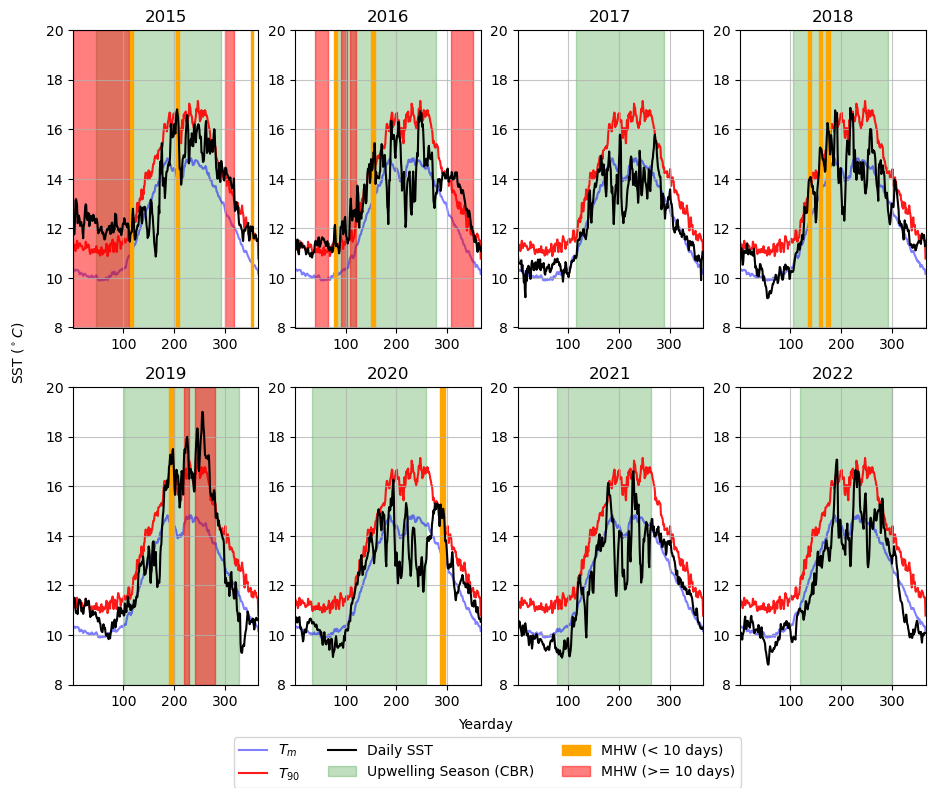

In [17]:
years = range(2015,2023)
fig = plt.figure(figsize = (11,8.5))
grid = (2,4)
ax1 = plt.subplot2grid(grid, (0,0), colspan = 1,rowspan = 1)
ax2 = plt.subplot2grid(grid, (0,1), colspan = 1,rowspan = 1)
ax3 = plt.subplot2grid(grid, (0,2), colspan = 1,rowspan = 1)
ax4 = plt.subplot2grid(grid, (0,3), colspan = 1,rowspan = 1)
ax5 = plt.subplot2grid(grid, (1,0), colspan = 1,rowspan = 1)
ax6 = plt.subplot2grid(grid, (1,1), colspan = 1,rowspan = 1)
ax7 = plt.subplot2grid(grid, (1,2), colspan = 1,rowspan = 1)
ax8 = plt.subplot2grid(grid, (1,3), colspan = 1,rowspan = 1)
axs = [ax1,ax2,ax3,ax4,ax5,ax6, ax7,ax8]


for year in years:
    idx = years.index(year)
    ax = axs[idx]
    ydf = df4[(df4.index >= datetime(year,1,1)) & (df4.index <= datetime(year,12,31))]
    ax.plot(df4clim.index, df4clim.sst, color = 'blue',alpha = 0.5,zorder = 1, label = r'$T_{m}$')
    ax.plot(df4_90.yd, df4_90.sst, color = 'red', alpha = 0.9, zorder = 1, label = r'$T_{90}$')
    ax.plot(ydf.yd, ydf.sst, color = 'black',zorder = 2, label = 'Daily SST')

    ax.set_title(str(year))
    ax.set_ylim(8,20)
    ax.set_xlim(1,366)
    
    SF = CBR[year]
    ax.axvspan(SF['spring'],SF['fall'], color = 'green',zorder = 0,alpha = 0.25, label = 'Upwelling Season (CBR)')

    _mhwdf = mhwdf[mhwdf.year == year]
    if len(_mhwdf) == 0: pass
    for idx, row in _mhwdf.iterrows():
        if row.D >= 10:
            ax.axvspan(int(row.Ts),int(row.Te),color = 'red',zorder = 1,alpha = 0.5, label = 'MHW (>= 10 days)')
        else:
            ax.axvspan(int(row.Ts),int(row.Te),color = 'orange',zorder = 1,alpha = 1, label = 'MHW (< 10 days)')

        if year == 2019:
            _handles, _labels = ax.get_legend_handles_labels()

    ax.grid(alpha = 0.75,zorder = 0)

_handles = _handles[:-1]
_labels = _labels[:-1]
fig.legend(_handles, _labels, ncol = 3, loc=(0.25,0))


fig.text(0.5, 0.063, 'Yearday', ha='center', va='center')
fig.text(0.075, 0.5, r'SST ($^\circ{C}$)', ha='center', va='center', rotation='vertical')
plt.savefig(figure_save_filepath, dpi = 1200)

## Figure: MHW Composites

In [18]:
figure_directory = f"{os.path.expanduser('~')}/oregon-shelf-mhw/figures"
os.makedirs(figure_directory, exist_ok = True)
figure_save_filepath = f"{os.path.expanduser('~')}/oregon-shelf-mhw/figures/mhw_composites.png"

In [19]:
df90 = ds4_90.to_dataframe()
avg = df90[(df90.yd >=190) & (df90.yd <= 276)].sst.mean()

/tmp/ipykernel_1252/1380105672.py:29: RuntimeWarning: Mean of empty slice
  z = np.nanmean(_sst,axis = 0)
/tmp/ipykernel_1252/1380105672.py:29: RuntimeWarning: Mean of empty slice
  z = np.nanmean(_sst,axis = 0)
/tmp/ipykernel_1252/1380105672.py:29: RuntimeWarning: Mean of empty slice
  z = np.nanmean(_sst,axis = 0)
/tmp/ipykernel_1252/1380105672.py:29: RuntimeWarning: Mean of empty slice
  z = np.nanmean(_sst,axis = 0)
/tmp/ipykernel_1252/1380105672.py:29: RuntimeWarning: Mean of empty slice
  z = np.nanmean(_sst,axis = 0)
/tmp/ipykernel_1252/1380105672.py:29: RuntimeWarning: Mean of empty slice
  z = np.nanmean(_sst,axis = 0)
/tmp/ipykernel_1252/1380105672.py:29: RuntimeWarning: Mean of empty slice
  z = np.nanmean(_sst,axis = 0)
/tmp/ipykernel_1252/1380105672.py:29: RuntimeWarning: Mean of empty slice
  z = np.nanmean(_sst,axis = 0)


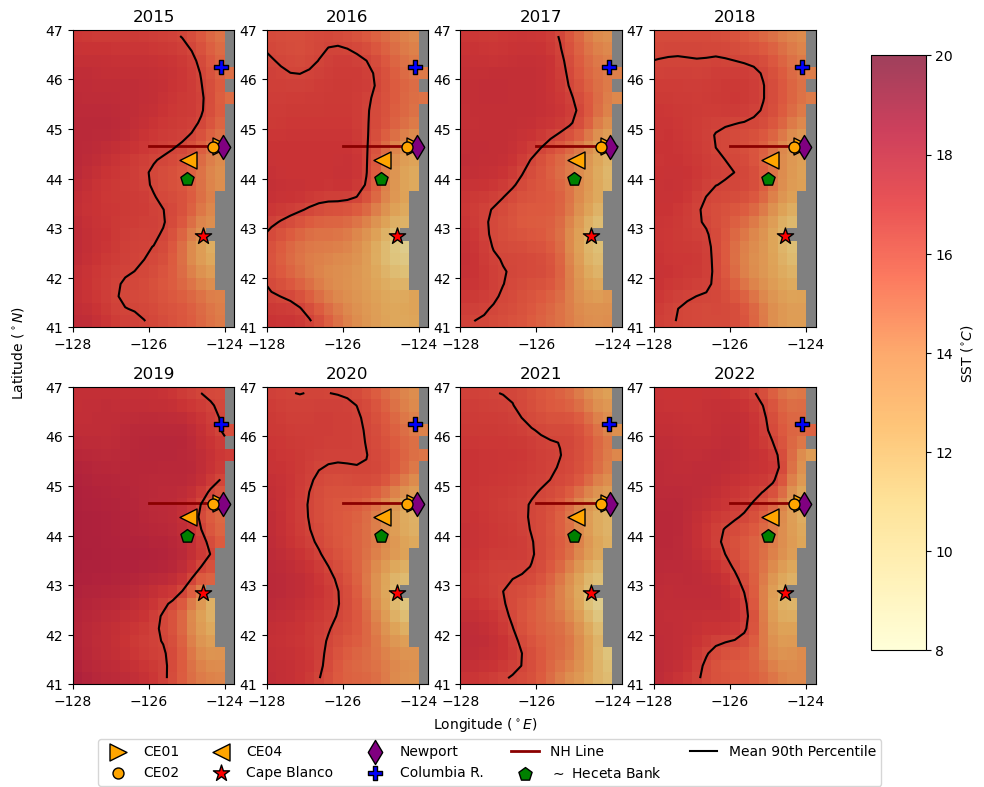

In [20]:
years = range(2015,2023)
fig = plt.figure(figsize = (11,8.5))
grid = (2,4)
ax1 = plt.subplot2grid(grid, (0,0), colspan = 1,rowspan = 1)
ax2 = plt.subplot2grid(grid, (0,1), colspan = 1,rowspan = 1)
ax3 = plt.subplot2grid(grid, (0,2), colspan = 1,rowspan = 1)
ax4 = plt.subplot2grid(grid, (0,3), colspan = 1,rowspan = 1)
ax5 = plt.subplot2grid(grid, (1,0), colspan = 1,rowspan = 1)
ax6 = plt.subplot2grid(grid, (1,1), colspan = 1,rowspan = 1)
ax7 = plt.subplot2grid(grid, (1,2), colspan = 1,rowspan = 1)
ax8 = plt.subplot2grid(grid, (1,3), colspan = 1,rowspan = 1)
axs = [ax1,ax2,ax3,ax4,ax5,ax6, ax7,ax8]


for year in years:
    idx = years.index(year)
    ax = axs[idx]
    ax.set_facecolor('gray')

    _ds = import_oisstv2_sst_mean([year])
    _ds['lon'] = _ds.lon-360
    dtr = pd.date_range(datetime(year,7,9), datetime(year,10,7))
    _sst = []
    for dt in dtr:
        dt_str = dt.strftime('%Y-%m-%d')
        daysst = _ds.sel(lon = slice(-129.75,-123.75),lat = slice(41,47),time = dt_str)
        _sst.append(np.array(daysst.sst))
        x,y = np.meshgrid(daysst.lon,daysst.lat)
    z = np.nanmean(_sst,axis = 0)
    
    p = ax.pcolormesh(x,y,z, vmin = 8, vmax = 20, cmap = 'YlOrRd',alpha = 0.75)
    contours = ax.contour(x,y,z,colors = ['black'], levels = [avg])
    
    ax.scatter(CE01_LOC[1], CE01_LOC[0], marker = '>', label = 'CE01', edgecolors = 'black',facecolors = 'orange', s= 150,zorder = 2)
    ax.scatter(CE02_LOC[1], CE02_LOC[0], marker = '.', label = 'CE02', edgecolors = 'black',facecolors = 'orange', s= 250,zorder = 3)
    ax.scatter(CE04_LOC[1], CE04_LOC[0], marker = '<', label = 'CE04', edgecolors = 'black',facecolors = 'orange', s = 150,zorder = 2)
    ax.scatter(BLANCO_LOC[1], BLANCO_LOC[0], marker = '*', label = 'Cape Blanco', edgecolors = 'black',facecolors = 'red', s = 150,zorder = 2)
    ax.scatter(NEWPORT_LOC[1], NEWPORT_LOC[0], marker = 'd', label = 'Newport', edgecolors = 'black',facecolors = 'purple', s = 150,zorder = 2)
    ax.scatter(CR_LOC[1], CR_LOC[0], marker = 'P', label = 'Columbia R.', edgecolors = 'black',facecolors = 'blue', s = 100,zorder = 2)
    ax.plot(NH_LINE[1],(NH_LINE[0],NH_LINE[0]), color = 'darkred', zorder = 1,linewidth = 2,label = 'NH Line')
    ax.scatter(HECETA_LOC[1], HECETA_LOC[0], marker = 'p', label = r'$\sim$ Heceta Bank', edgecolors = 'black',facecolors = 'green', s = 100,zorder = 2)
    ax.plot([],[],color = 'black',label = 'Mean 90th Percentile')
    
    ax.set_title(year)
    if year == 2019:
        _handles, _labels = ax.get_legend_handles_labels()
    
    ax.set_xlim(-128, -123.75)
    
fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax, label = r'SST ($^{\circ}C$)')

fig.text(0.5, 0.063, r'Longitude ($^\circ{E}$)', ha='center', va='center')
fig.text(0.075, 0.5, r'Latitude ($^\circ{N}$)', ha='center', va='center', rotation='vertical')

fig.legend(_handles, _labels, ncol = 5, loc = (0.1,0.001))

plt.savefig(figure_save_filepath,dpi = 1200)